# <center>Assignment 2 LSTM - Fixed Window Size Loop with First Order Difference

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Basic Time Series Setting
import statsmodels.api as smapi
import statsmodels.tsa.api as smt

In [3]:
# RNN Package Setting
import time
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import optimizers

np.random.seed(1)

Using Theano backend.


## Data Preparation

In [4]:
data=pd.read_csv('internet_retail_sales.csv',parse_dates=[0], index_col=0)
sales=data.values

### First Order Difference

In [5]:
sales_diff=pd.Series.diff(data)
sales_diff=sales_diff.dropna().values
# sales_diff

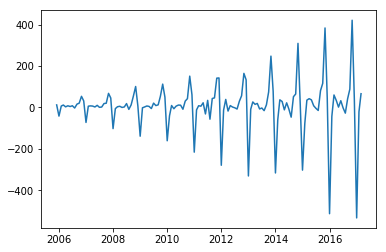

In [95]:
fig=plt.figure()
date=pd.date_range(start='11/10/2005',end='03/01/2017',freq='MS')
plt.figure()
plt.plot(date,sales_diff)
plt.show()
fig.savefig('1stord.png',dpi=1000)

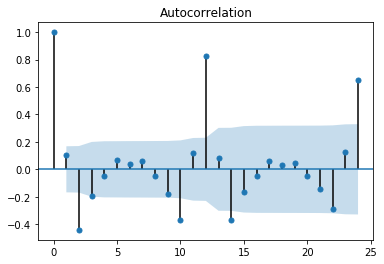

In [93]:
fig=smt.graphics.plot_acf(sales_diff, lags=24)
plt.show()
fig.savefig('ACF.png',dpi=1000)

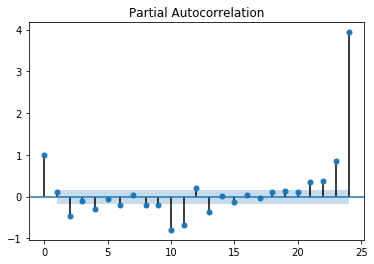

In [92]:
fig=smt.graphics.plot_pacf(sales_diff, lags=24)
plt.show()
fig.savefig('PACF.png',dpi=1000)

### Standardisation - Trend Standardisation

In [6]:
# Standardisation
scaler = StandardScaler()
diff_scaled=scaler.fit_transform(sales_diff)

# Std & Mean Calculation
diff_std=np.std(sales_diff)
diff_mean=np.mean(sales_diff)

print(diff_std)
print(diff_mean)

114.26257030851261
7.280147058823529


## RNN-Fixed Window Size Model Fitting

### Trend Model Fitting

In [85]:
# Model Fitting
epochs=100
repeats=5

neurons_min=30
neurons_max=31

window_min=2
window_max=3

step=1

# train_loss=np.zeros(shape=(window_max-window_min,int((neurons_max-neurons_min)/5)))
# cv_loss=np.zeros(shape=(window_max-window_min,int((neurons_max-neurons_min)/5)))
# test_loss=[np.zeros(shape=(window_max-window_min,int((neurons_max-neurons_min)/5)))]
train_loss=[]
train_loss_res=[]

cv_loss=[]
cv_loss_res=[]

test_loss=[]

for w in range(window_min,window_max):
       
    time_window=w
    
    Xall, yall=[],[]
    for i in range(time_window, len(diff_scaled)):
        Xall.append(diff_scaled[i-time_window:i,0])
        yall.append(diff_scaled[i,0])     
    Xall=np.array(Xall)
    yall=np.array(yall)
    
    # Real Train Test Split
    test_size=12
    Xtrain, Xtest=Xall[0:-test_size], Xall[-test_size:]
    ytrain, ytest=yall[0:-test_size], yall[-test_size:]
    
    # Unscaled Data Preparation for Evaluation
    y_train_raw=sales_diff[0:-test_size]
    y_test_raw=sales_diff[-test_size:]   

    # Validation Train Test Split
    Xtrain_pse, Xtest_pse=Xtrain[0:-test_size], Xtrain[-test_size:]
    ytrain_pse, ytest_pse=ytrain[0:-test_size], ytrain[-test_size:]
    # Unscaled Data Preparation for Evaluation
    # Trend
    y_train_pse_raw=y_train_raw[0:-test_size]
    y_test_pse_raw=y_train_raw[-test_size:]    

    # Real Train Test Split Reshape 
    Xtrain, Xtest=Xtrain.reshape(Xtrain.shape[0], time_window, 1), Xtest.reshape(Xtest.shape[0], time_window, 1)
    # Validation Train Test Split Reshape
    Xtrain_pse, Xtest_pse=Xtrain_pse.reshape(Xtrain_pse.shape[0], time_window, 1), Xtest_pse.reshape(Xtest_pse.shape[0], time_window, 1)


    for n in range(neurons_min,neurons_max,step):
    #         fig=plt.figure()  
        rmse_t=[]
        for j in range(repeats):

            model=Sequential()
            model.add(LSTM(n,input_shape = (time_window,1), batch_size=1,stateful=True))
            model.add(Dropout(0.2))
            model.add(Dense(1,activation='linear'))
            #     model.add(Dense(1))

            # compile model for use
            start=time.time()
            model.compile(loss="mse", optimizer="rmsprop")
            print("Compilation Time : ", time.time() - start)

            train_loss_t=[]
            cv_loss_t=[]   
            for i in range(epochs):
                history=model.fit(Xtrain_pse,ytrain_pse, epochs=1, batch_size=1, verbose=2,validation_split=0.1,shuffle=False)
                train_loss_t.append(history.history['loss'])
                cv_loss_t.append(history.history['val_loss'])
                model.reset_states()

            # Loss Calculation  
            # Test RMSE - For my own happiness
            test_predict_pse = model.predict(Xtest_pse,batch_size=1)
            test_predict_pse=scaler.inverse_transform(test_predict_pse)  
            
            # Trend RMSE
            rmse_t.append(math.sqrt(mean_squared_error(y_test_pse_raw,test_predict_pse)))
                
            # cross validation loss
            cv_loss.append(np.array(cv_loss_t))
            cv_loss_res.append(np.array(cv_loss_t)*diff_std)
            # training loss
            train_loss.append(np.array(train_loss_t))            
            train_loss_res.append(np.array(train_loss_t)*diff_std)
        
        # TREND            
        rmse_t.append(np.mean(rmse_t)) # calculate mean and std of Trend RMSE
        rmse_t.append(np.std(rmse_t))
        test_loss.append(rmse_t) # append mean and std of rmse

# plt.plot(train_loss,color='blue')
# plt.plot(cv_loss,color='orange')
    
# plt.title('model train vs validation loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# # # plt.legend(['train', 'validation'], loc='upper right')
# plt.show()
# fig.savefig('epochs_tuning.png',dpi=1000)

Compilation Time :  0.017949342727661133
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4853 - val_loss: 1.2908
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4667 - val_loss: 1.1963
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4393 - val_loss: 1.0962
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4044 - val_loss: 0.9932
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.4001 - val_loss: 0.9112
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.3791 - val_loss: 0.8446
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.3679 - val_loss: 0.7866
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.3519 - val_loss: 0.7473
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.3144 - val_loss: 0.6926
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.3114 - val_loss: 0.6546
Train on 99 samples

Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.0818 - val_loss: 0.4043
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.0919 - val_loss: 0.3671
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1224 - val_loss: 0.3439
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.0764 - val_loss: 0.3429
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1025 - val_loss: 0.3825
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.0713 - val_loss: 0.3876
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.0749 - val_loss: 0.3588
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1445 - val_loss: 0.3728
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.0752 - val_loss: 0.3776
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.0819 - val_loss: 0.4068
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1257 - val_loss: 0.3739
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.0915 - val_loss: 0.3005
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1017 - val_loss: 0.3628
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1020 - val_loss: 0.3043
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.0776 - val_loss: 0.2814
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1098 - val_loss: 0.3076
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.0767 - val_loss: 0.2625
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1027 - val_loss: 0.3798
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.0530 - val_loss: 0.2921
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.0726 - val_loss: 0.2847
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.0802 - val_loss: 0.3223
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1173 - val_loss: 0.3712
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1239 - val_loss: 0.3556
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1199 - val_loss: 0.3526
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1048 - val_loss: 0.3633
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1384 - val_loss: 0.3631
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1161 - val_loss: 0.3435
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1032 - val_loss: 0.2924
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.7058 - val_loss: 0.3111
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1203 - val_loss: 0.3138
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1041 - val_loss: 0.5150
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1130 - val_loss: 0.5612
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.0937 - val_loss: 0.5838
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1373 - val_loss: 0.4383
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1087 - val_loss: 0.4273
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1300 - val_loss: 0.4356
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1063 - val_loss: 0.4411
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1295 - val_loss: 0.4375
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1231 - val_loss: 0.4662
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.0925 - val_loss: 0.3639
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s 

Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1341 - val_loss: 0.5628
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1158 - val_loss: 0.5865
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1206 - val_loss: 0.5360
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1152 - val_loss: 0.5621
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1344 - val_loss: 0.5556
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1431 - val_loss: 0.6250
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1135 - val_loss: 0.5996
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1240 - val_loss: 0.6472
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1352 - val_loss: 0.6826
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s - loss: 0.1367 - val_loss: 0.6157
Train on 99 samples, validate on 11 samples
Epoch 1/1
 - 0s 

In [87]:
test_loss

[[132.649483329197,
  143.88501537266393,
  140.70921723254136,
  153.48612415401533,
  115.31462961473129,
  137.2088939406298,
  11.704116935496621]]

In [88]:
# test_loss_sum=[]
# test_loss_multi_sum=[]

test_loss_sum.append(np.array(test_loss))
# test_loss_multi_sum.append(np.array(test_loss_multi))

In [89]:
print(test_loss_sum)

[array([[1.91324017e+02, 1.91492322e+02, 1.91408170e+02, 6.87101905e-02]]), array([[190.93881181, 187.17665108, 190.46606364, 191.11883184,
        181.11523277, 190.3488099 , 191.80393509, 187.95840399,
        195.26616003, 186.85521851, 189.30481187,   3.43238516]]), array([[191.14915579, 190.93513124, 191.0967415 , 180.21907407,
        187.77013476, 190.57384856, 181.68392676, 189.16905807,
        179.76358764, 183.45976592, 186.58204243,   4.31643775]]), array([[186.15050029, 199.53407071, 173.87001669, 186.68803253,
        181.31358748, 185.51124154,   7.65475497]]), array([[147.08326472, 158.11538864, 183.66075522, 135.01148565,
        147.80326644, 154.33483213,  14.96073011]]), array([[141.28318535, 134.58001953, 118.89704648, 122.97007618,
        148.47817256, 133.24170002,  10.08201387]]), array([[162.81212534, 162.88886188, 144.3440681 , 147.74639696,
        141.25950253, 151.81019096,   8.43952949]]), array([[119.93114158, 133.28336807, 132.4630871 , 126.54003188,
  

In [62]:
# cv_loss

In [63]:
# cv_loss_res

In [65]:
# train_loss_res

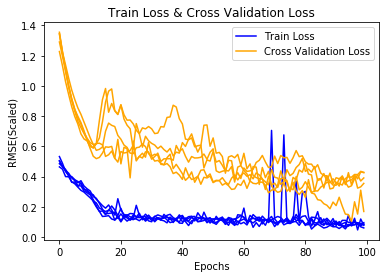

In [90]:
# Cross Validation Visualization
fig=plt.figure()
line1=plt.plot(np.array(train_loss)[0,:],color='blue',label="Train Loss")
plt.plot(np.array(train_loss)[1,:],color='blue')
plt.plot(np.array(train_loss)[2,:],color='blue')
plt.plot(np.array(train_loss)[3,:],color='blue')
plt.plot(np.array(train_loss)[4,:],color='blue')
# plt.plot(np.array(train_loss)[5,:],color='blue')
# plt.plot(np.array(train_loss)[6,:],color='blue')
# plt.plot(np.array(train_loss)[7,:],color='blue')
# plt.plot(np.array(train_loss)[8,:],color='blue')
# plt.plot(np.array(train_loss)[9,:],color='blue')

line2=plt.plot(np.array(cv_loss)[0,:],color='orange',label= "Cross Validation Loss")
plt.plot(np.array(cv_loss)[1,:],color='orange')
plt.plot(np.array(cv_loss)[2,:],color='orange')
plt.plot(np.array(cv_loss)[3,:],color='orange')
plt.plot(np.array(cv_loss)[4,:],color='orange')
# plt.plot(np.array(cv_loss)[5,:],color='orange')
# plt.plot(np.array(cv_loss)[6,:],color='orange')
# plt.plot(np.array(cv_loss)[7,:],color='orange')
# plt.plot(np.array(cv_loss)[8,:],color='orange')
# plt.plot(np.array(cv_loss)[9,:],color='orange')


plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE(Scaled)')
plt.title('Train Loss & Cross Validation Loss')
plt.show()
fig.savefig('loss_output.png',dpi=1000)

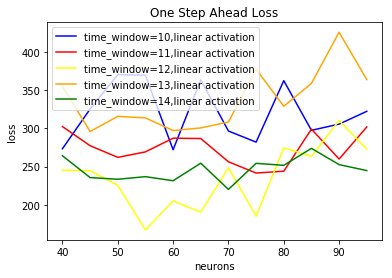

In [268]:
fig=plt.figure()
plt.plot(np.arange(40,100,5),test_loss.iloc[0,:],label='time_window=10,linear activation',color='blue')
plt.plot(np.arange(40,100,5),test_loss.iloc[1,:],label='time_window=11,linear activation',color='red')
plt.plot(np.arange(40,100,5),test_loss.iloc[2,:],label='time_window=12,linear activation',color='yellow')
plt.plot(np.arange(40,100,5),test_loss.iloc[3,:],label='time_window=13,linear activation',color='orange')
plt.plot(np.arange(40,100,5),test_loss.iloc[4,:],label='time_window=14,linear activation',color='green')
plt.legend()
plt.xlabel('neurons')
plt.ylabel('loss')
plt.title('One Step Ahead Loss')
plt.show()
fig.savefig('loss_output.png',dpi=1000)

In [269]:
test_loss.to_excel('Loss_T10-14_N40-100.xlsx')

In [200]:
# Predict
train_predict = model.predict(Xtrain,batch_size=1)
test_predict = model.predict(Xtest,batch_size=1)

# Inverse Prediction
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

## Training Score

In [201]:
# epochs_summary=[]
# neurons_summary=[]
# rmse_summary=[]
# mae_summary=[]

In [202]:
rmse=math.sqrt(mean_squared_error(y_test_raw,test_predict))
mae=mean_absolute_error(y_test_raw,test_predict)

In [203]:
epochs_summary.append(epochs)
neurons_summary.append(neurons)
rmse_summary.append(rmse)
mae_summary.append(mae)

print(epochs_summary)
print(neurons_summary)
print(rmse_summary)
print(mae_summary)

[300, 300, 300, 300, 300, 300, 300]
[5, 10, 50, 100, 150, 125, 113]
[318.7349936417306, 230.30975251899886, 208.24286191876573, 134.40613515925975, 299.2879239417023, 338.1812868338608, 225.34691825042538]
[260.30489908854173, 126.15896402994788, 146.3288401285807, 111.27141418457029, 243.473257446289, 287.5988016764323, 174.387559000651]


## Diagnostic Plot

ZeroDivisionError: integer division or modulo by zero

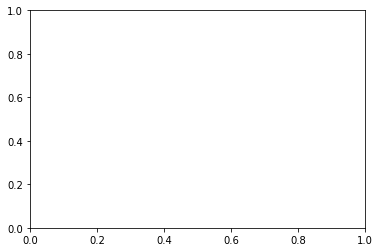

In [101]:
fig=plt.figure()
plt.plot(train_loss_summary)
plt.plot(cv_loss_summary)
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
fig.savefig('epochs_tuning.png',dpi=1000)

In [102]:
train_loss_summary

""
